# Adversarial examples
This notebook is inspired by the neural-nets-are-weird notebook found in [this](https://github.com/jvns/neural-nets-are-weird) github repo.

## First, we need to set up the network, preprocessing and get some data
We with some imports and basic settings

In [1]:
import numpy as np
import matplotlib.pyplot as ppt
import caffe

%matplotlib inline
caffe.set_mode_cpu()

caffe_root = '/home/chrisbot/Projects/caffe'
data_root = '/home/chrisbot/Projects/master-thesis/images'

We load the labels for the network

In [2]:
imagenet_labels_filename = caffe_root + '/data/ilsvrc12/synset_words.txt'
try:
    imagenet_labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')
except IOError: # If the data is not found, let this caffe script download it
    !{caffe_root}/data/ilsvrc12/get_ilsvrc_aux.sh
    imagenet_labels = np.loadtxt(imagenet_labels_filename, str, delimiter='\t')

for index, l in enumerate(imagenet_labels):
    #imagenet_labels[index] = l[10:].split(',')[0]
    imagenet_labels[index] = l #FIXME Use the one above

Next, we define a function to load the network and a transformer that will bring our images to the correct format

In [3]:
BATCH_SIZE = 1 # how many images to process at once

def load_model():
    net = caffe.Net(caffe_root + '/models/bvlc_googlenet/deploy.prototxt',
                    caffe_root + '/models/bvlc_googlenet/bvlc_googlenet.caffemodel',
                    caffe.TEST)
    shape = list(net.blobs['data'].data.shape)
    shape[0] = BATCH_SIZE
    net.blobs['data'].reshape(*shape)
    net.blobs['prob'].reshape(BATCH_SIZE, )
    net.reshape()
    return net

net = load_model()

transformer = caffe.io.Transformer( {'data': net.blobs['data'].data.shape} )
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255) # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0)) # the reference model has channels in BGR order instead of RGB

Some more auxiliary functions

In [4]:
def display(image, preds=[], probs=[], prediction_count=5):
    image_deprocessed = transformer.deprocess('data', image)
    ppt.imshow(image_deprocessed)
    
    try:
        # Set image title with most likely prediction
        label = imagenet_labels[preds[0]]
        probability = probs[preds[0]]
        ppt.title( '{0}: {1}% certainty'.format(label, round(probability*100, 2)) )

        # print the remaining predictions to stdout
        for ind, p in enumerate(preds):
            if ind > prediction_count:
                break
            label = imagenet_labels[p]
            probability = probs[p]
            print( '{0}: {1}% certainty'.format(label, round(probability*100, 2)) )
    except IndexError:
        pass # there were no predictions for this image
    
    ppt.show()

def predict(image):
    net.blobs['data'].data[...] = image
    probabilities = net.forward()['prob'][0]
    predictions = probabilities.argsort()[::-1]
    
    return predictions, probabilities

We are gonna need data for this

In [5]:
data_filenames = ['cat.jpg', 'dog.jpg', 'fence.jpg', 'kitten.jpg', 'panda.jpg', 'queen.jpg', 'sword.jpg', 'vulture.jpg']

data = {}
for df in data_filenames:
    image = caffe.io.load_image(data_root + '/' + df)
    data[df] = transformer.preprocess('data', image)

To test all this, we can let the network predict on this data

n01616318 vulture: 99.97% certainty
n01608432 kite: 0.01% certainty
n02018795 bustard: 0.01% certainty
n01798484 prairie chicken, prairie grouse, prairie fowl: 0.0% certainty
n01795545 black grouse: 0.0% certainty
n01518878 ostrich, Struthio camelus: 0.0% certainty


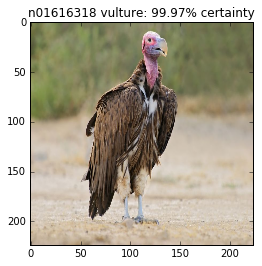

n02123159 tiger cat: 36.56% certainty
n02123045 tabby, tabby cat: 23.27% certainty
n02124075 Egyptian cat: 18.86% certainty
n02127052 lynx, catamount: 5.54% certainty
n02971356 carton: 2.45% certainty
n02123394 Persian cat: 2.1% certainty


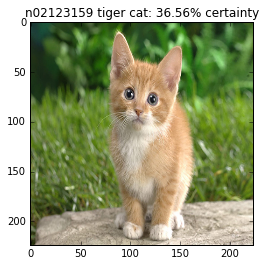

n02113023 Pembroke, Pembroke Welsh corgi: 43.12% certainty
n02088364 beagle: 26.22% certainty
n02113186 Cardigan, Cardigan Welsh corgi: 14.33% certainty
n02099601 golden retriever: 3.29% certainty
n02085620 Chihuahua: 2.53% certainty
n02086646 Blenheim spaniel: 2.05% certainty


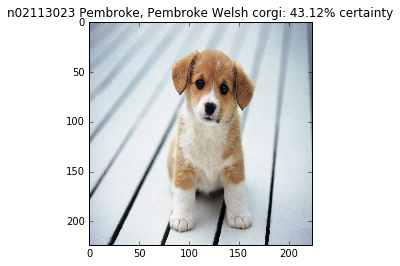

n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 99.23% certainty
n04399382 teddy, teddy bear: 0.16% certainty
n02509815 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 0.12% certainty
n02441942 weasel: 0.06% certainty
n02497673 Madagascar cat, ring-tailed lemur, Lemur catta: 0.05% certainty
n02447366 badger: 0.04% certainty


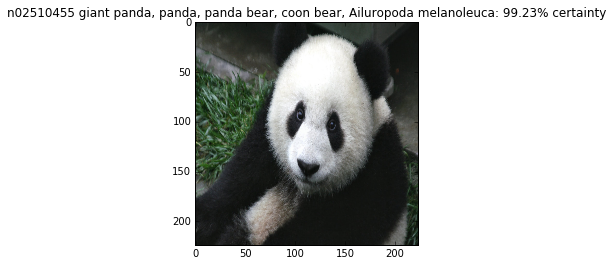

n04209133 shower cap: 99.57% certainty
n02869837 bonnet, poke bonnet: 0.29% certainty
n04584207 wig: 0.14% certainty
n02807133 bathing cap, swimming cap: 0.0% certainty
n03485794 handkerchief, hankie, hanky, hankey: 0.0% certainty
n03476684 hair slide: 0.0% certainty


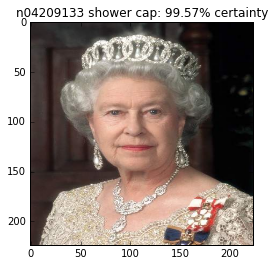

n03930313 picket fence, paling: 64.08% certainty
n04604644 worm fence, snake fence, snake-rail fence, Virginia fence: 35.85% certainty
n03733281 maze, labyrinth: 0.01% certainty
n04040759 radiator: 0.01% certainty
n04532670 viaduct: 0.01% certainty
n04326547 stone wall: 0.0% certainty


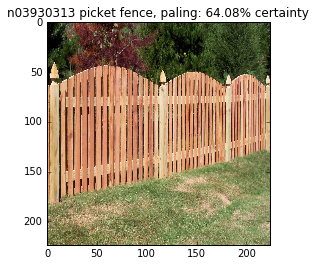

n02124075 Egyptian cat: 36.86% certainty
n02123045 tabby, tabby cat: 33.74% certainty
n02123159 tiger cat: 14.65% certainty
n02127052 lynx, catamount: 2.24% certainty
n03887697 paper towel: 1.97% certainty
n03958227 plastic bag: 1.54% certainty


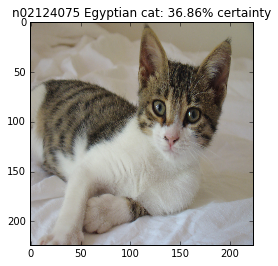

n03658185 letter opener, paper knife, paperknife: 81.95% certainty
n04141327 scabbard: 17.74% certainty
n03804744 nail: 0.07% certainty
n04033901 quill, quill pen: 0.04% certainty
n03476684 hair slide: 0.03% certainty
n03109150 corkscrew, bottle screw: 0.02% certainty


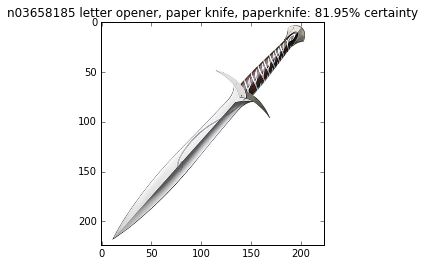

In [6]:
for d in data.keys():
    preds, probs = predict(data[d])
    display(data[d], preds, probs)

## Turning a panda into a vulture
Now that we got our network up and running, it is time to turn a panda into a vulture! First of all, we check what the network thinks of the unaltered panda.

n02510455 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca: 99.23% certainty
n04399382 teddy, teddy bear: 0.16% certainty
n02509815 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens: 0.12% certainty
n02441942 weasel: 0.06% certainty
n02497673 Madagascar cat, ring-tailed lemur, Lemur catta: 0.05% certainty
n02447366 badger: 0.04% certainty


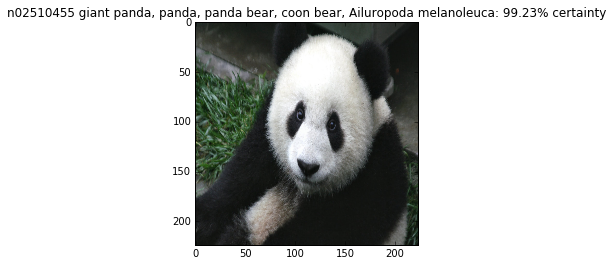

388


In [7]:
preds, probs = predict(data['panda.jpg'])
display(data['panda.jpg'], preds, probs)
print(preds[0])

Ok, so the network is quite sure that this image shows a panda. Now we need to make it more like a vulture in a subtle way. To do this, we compute the gradient of the loss function w.r.t. the input image.

$$ \nabla L = \frac{d}{d \ \text{image}} \ L(\text{pred}, \text{label}) $$

The loss depends on two components, the prediction $\text{pred}$ of the network and the $\text{label}$ for a given input. We are going to use a **false label**, e.g. a vulture label when running the network on an image of a panda. This way, backpropagation will compute a gradient for the image that changes it such that the network thinks it is a vulture.

$$ \text{image}' = \text{image} + \nabla L $$

First, we are gonna look at the gradient.

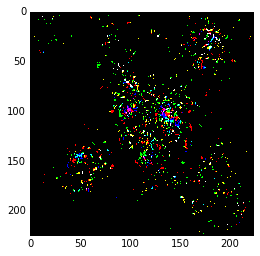

In [8]:
def compute_gradient(image, intended_outcome):
    _, _ = predict(image)
    probs = np.zeros_like(net.blobs['prob'].data)
    probs[0][intended_outcome] = 1
    
    gradient = net.backward(prob=probs, diffs=['data'])
    return gradient['data'].copy()

panda_label = 388
vulture_label = 23
cat_label = 282
gradient = compute_gradient(data['panda.jpg'], vulture_label)
display(gradient / np.percentile(gradient, 98))

That doesn't look much like a vulture, but the network considers these the relevant parts that are needed to turn a panda into a vulture. So let's do it.

n01616318 vulture: 96.96% certainty
n01518878 ostrich, Struthio camelus: 0.57% certainty
n02483362 gibbon, Hylobates lar: 0.47% certainty
n02058221 albatross, mollymawk: 0.37% certainty
n02497673 Madagascar cat, ring-tailed lemur, Lemur catta: 0.32% certainty
n02500267 indri, indris, Indri indri, Indri brevicaudatus: 0.14% certainty


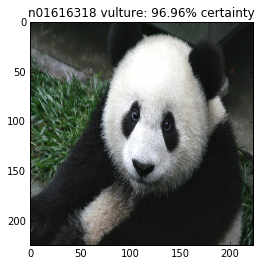

In [9]:
def turn_into(image, desired_label, iterations):
    changed_image = image.copy()
    
    pred_history, prob_history = predict(changed_image)
    for _ in range(iterations):
        gradient = compute_gradient(changed_image, desired_label)
        changed_image = changed_image + (0.9 / iterations) * np.sign(gradient)
        
        preds, probs = predict(changed_image)
        pred_history = np.vstack([pred_history, preds])
        prob_history = np.vstack([prob_history, probs])
    
    return changed_image, pred_history, prob_history

pseudo_vulture, pred_history, prob_history = turn_into(data['panda.jpg'], vulture_label, 10)
pseudo_vulture = pseudo_vulture[0,...]

preds, probs = predict(pseudo_vulture)
display(pseudo_vulture, preds, probs)

The *turn_into* function keeps a record of the probabilities over time. How do they look for the panda and vulture, respectively?

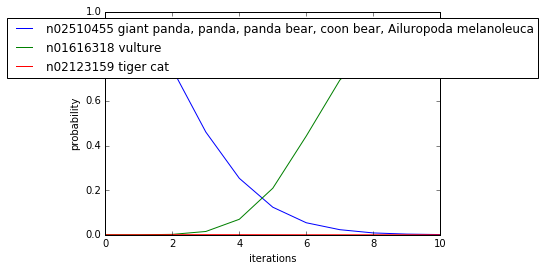

In [10]:
def plot_probabilities(pred_history, prob_history, labels):
    for l in labels:
        probs = prob_history[:, l]
        ppt.plot(probs, label=imagenet_labels[l])
        ppt.legend(loc='upper center')
    
    ppt.xlabel('iterations')
    ppt.ylabel('probability')

plot_probabilities(pred_history, prob_history, [panda_label, vulture_label, cat_label])

We can see that the network slowly gets convinced that the panda is a vulture. But how has the image changed? As we can see above, it is visually indistinguishable, but some values must have changed. Since we used an iterative process, displaying the gradient is not enough. Instead, we look at the (magnified) difference between the unmodified panda and the panda-vulture chimera.

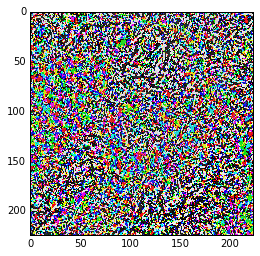

In [11]:
difference = data['panda.jpg'] - pseudo_vulture
display(difference * 50)

-3.5558330679
2.8328938993


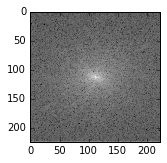

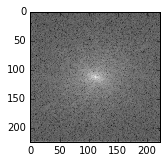

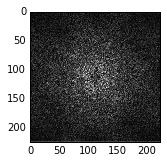

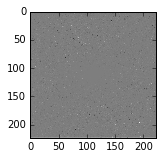

In [12]:
def display_original_size(image, dpi):
    size_in_inches = (image.shape[2] / float(dpi), image.shape[1] / float(dpi))
    fig = ppt.figure(figsize=(size_in_inches), dpi=dpi)
    ppt.imshow(image[0], cmap='gray', interpolation='none')

def get_spectrum(image):
    spectrum = np.fft.fft2(image)
    spectrum = np.fft.fftshift(spectrum)
    return np.abs(spectrum)

panda_spectrum = get_spectrum(data['panda.jpg'])
display_original_size( np.log(panda_spectrum) , 96)

pseudo_vulture_spectrum = get_spectrum(pseudo_vulture)
display_original_size( np.log(pseudo_vulture_spectrum), 96)

diff_spectrum = get_spectrum(data['panda.jpg'] - pseudo_vulture)
display_original_size( diff_spectrum, 96 )

diff = np.log(panda_spectrum) - np.log(pseudo_vulture_spectrum)
display_original_size( diff, 99)

print(np.min(diff))
print(np.max(diff))

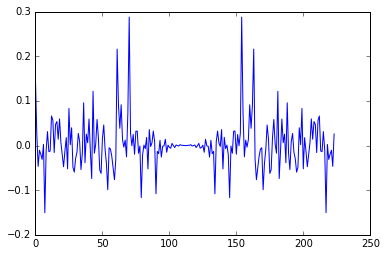

In [13]:
height = diff.shape[1]
diff_slice = diff[:,height / 2,:]
diff_slice = diff_slice
ppt.plot(diff_slice[0,...])

panda_spectrum_slice = np.log(panda_spectrum)[:,height / 2,:]
#ppt.plot(panda_spectrum_slice[0,...])

panda_adversarial_spectrum_slice = np.log(pseudo_vulture_spectrum)[:,height / 2,:]
#ppt.plot(panda_adversarial_spectrum_slice[0,...])

## Making a panda unlike a panda
Instead of using the gradient to turn a panda into a vulture, we can use it to make a panda lose its *panda-ness*. To do this, we compute the gradient again, but tell the loss function we actually want a panda, not a vulture. This gives us  a gradient that makes the panda more like a panda. So this time, we subtract it instead of adding it. Again, we do this iteratively.

In [ ]:
def make_unlike_self(image, true_label, iterations):
    changed_image = image.copy()
    
    pred_history, prob_history = predict(changed_image)
    for _ in range(iterations):
        gradient = compute_gradient(changed_image, true_label)
        changed_image = changed_image - (0.9 / iterations) * np.sign(gradient)
        
        preds, probs = predict(changed_image)
        pred_history = np.vstack([pred_history, preds])
        prob_history = np.vstack([prob_history, probs])
    
    return changed_image, pred_history, prob_history

not_panda, pred_history, prob_history = make_unlike_self(data['panda.jpg'], panda_label, 10)

preds, probs = predict(not_panda)
display(not_panda, preds, probs)
print('{0} probability: {1}%'.format( imagenet_labels[panda_label], round(probs[panda_label] * 100, 2) ))